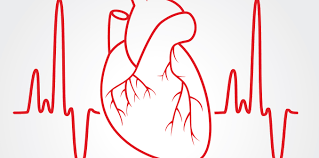


<font color='red'>**If you like my work,please consider giving an upvote !!!**</font>


**INTRODUCTION**

In this notebook i want to predict different arrhytmia on ECG. We have two different dataset, but i will consider at start only one : mitbih.
The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.
souces : https://physionet.org/content/mitdb/1.0.0/


Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]


-N : Non-ecotic beats (normal beat)
-S : Supraventricular ectopic beats
-V : Ventricular ectopic beats
-F : Fusion Beats
-Q : Unknown Beats

**What is an ecg? **

An electrocardiogram (ECG) is a simple test that can be used to check your heart's rhythm and electrical activity.

Sensors attached to the skin are used to detect the electrical signals produced by your heart each time it beats.

These signals are recorded by a machine and are looked at by a doctor to see if they're unusual.

An ECG may be requested by a heart specialist (cardiologist) or any doctor who thinks you might have a problem with your heart, including your GP.
That's the result of this test we will analyze. 

**Load Data**

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')


In [ ]:
train_df=pd.read_csv('/kaggle/input/without1-3/mitbih_train.csv',header=None)
test_df=pd.read_csv('/kaggle/input/without01-03/mitbih_test.csv',header=None)

**Balance of dataset**

In [ ]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)



In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','v','f'], colors=['red','blue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

We can underligned a huge difference in the balanced of the classes. After some try i have decided to  choose the resample technique more than the class weights for the algorithms. 

In [ ]:
from sklearn.utils import resample
#df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
#df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

#df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
#df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_2_upsample,df_4_upsample])

In [ ]:
equilibre=train_df[187].value_counts()
print(equilibre)


In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','v','f'], colors=['red','blue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Resample works perfectly we can go on. 

**Classes**

In this part i want to study the differente classes. 

In [ ]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

I take one sample per class and i store it in a datafrmae in order to have an exmeple. 

In [ ]:
c

In [ ]:
 plt.plot(c.iloc[1,:186])

Here is a normal beat. I don't have something particular to say on that class.  

In [ ]:
def plot_hist(class_number,size,min_):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()

In [ ]:
plot_hist(0,70,5)

Here is a representation for all the class. We take all the signal and map them. Like that we have an estimation what the signal can look like.

In [ ]:
 plt.plot(c.iloc[1,:186])

In [ ]:
plot_hist(0,50,5)

In [ ]:
 plt.plot(c.iloc[2,:186])

In [ ]:
plot_hist(2,60,30)

Here is an exemple of the two classes :

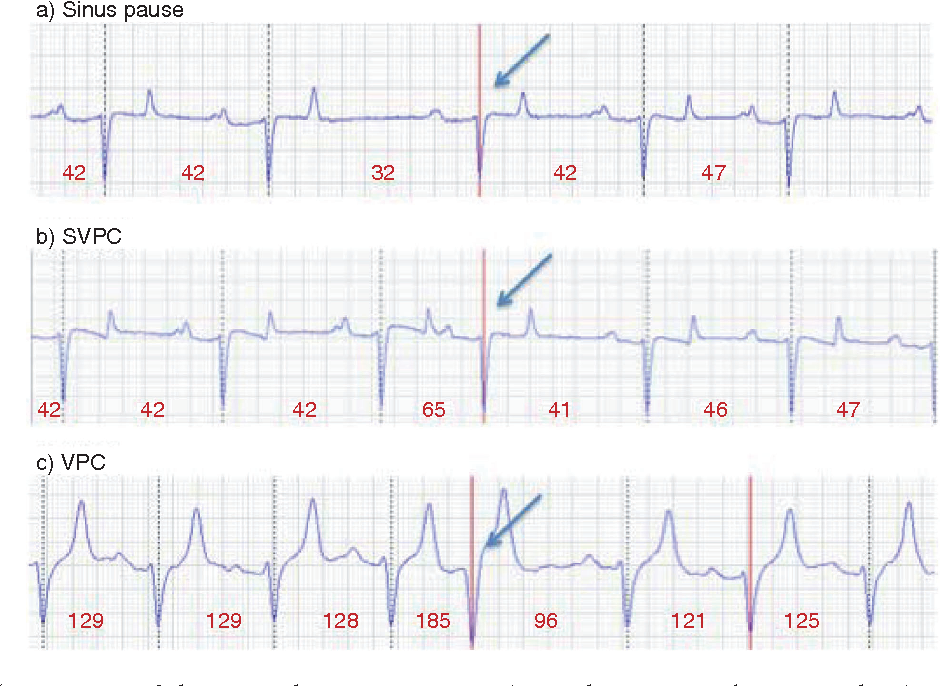

in the second and third line you have the 2 et 3 class.

In [ ]:
plt.plot(c.iloc[2,:186])

In [ ]:
plot_hist(2,60,25)

Fusion beat :
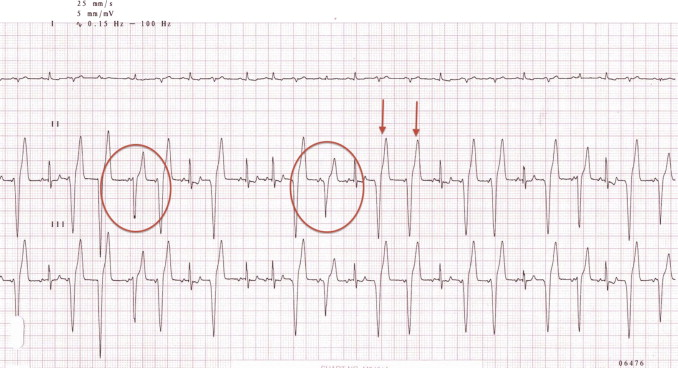

Don't really see the difference with the previous one but i'm not an expert of ECG!

In [ ]:
plt.plot(c.iloc[0,:186])

I will not comment a lot this one because it correspond to other class. 

In [ ]:
plot_hist(4,50,18)

**Pretreat**

In this part i will speak o n what i do to transform data. 

In [ ]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)


I use a fonction ( will depend of the version) where i add a noise to the data to generilize my train.

In [ ]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()



In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [ ]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

**Network**

In [ ]:
def network(X_train,y_train,X_test,y_test):
    
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="valid")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    
    conv4_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool3)
    conv4_1=BatchNormalization()(conv4_1)
    pool4=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv4_1)
    conv5_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool4)
    conv5_1=BatchNormalization()(conv3_1)
    pool5=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv5_1)
    
    conv6_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool5)
    conv6_1=BatchNormalization()(conv6_1)
    pool6=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv6_1)
    
    conv7_1=Convolution1D(64, (3), activation='swish', input_shape=im_shape)(pool6)
    conv7_1=BatchNormalization()(conv7_1)
    pool7=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv7_1)
    flatten=Flatten()(pool7)
    dense_end1 = Dense(300, activation='tanh')(flatten)
    dense_end2 = Dense(200, activation='tanh')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=30,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','2','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [ ]:

from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)



In [ ]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)


i take the next function from : https://www.kaggle.com/coni57/model-from-arxiv-1805-00794

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'V', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()



We underlign that two class(supraventricular and fusion) is weeker than the other. maybe due to less exemple in the starter dataset. I will try to improve in the next version.

In [ ]:
import pandas as pd
mitbih_test = pd.read_csv("../input/mitbih_test.csv")